In [2]:
import torch

CLEAN_pid2emb = torch.load('../data/ec/sprot_10_1022_CLEAN_ec_above_10_single_label.pt')
test_data = torch.load('../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_test.pt')
train_data = torch.load('../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_train.pt')
train_CLEAN_emb = torch.vstack([CLEAN_pid2emb[pid] for pid in train_data])
train_labels = [train_data[pid]['ec'][0] for pid in train_data]
test_CLEAN_emb = torch.vstack([CLEAN_pid2emb[pid] for pid in test_data])
test_labels = [test_data[pid]['ec'][0] for pid in test_data]
print(train_CLEAN_emb.shape, test_CLEAN_emb.shape)
train_label2emb = {}
n_train, n_test = len(train_labels), len(test_labels)
for i in range(n_train):
    label = train_labels[i]
    if label not in train_label2emb:
        train_label2emb[label] = []
    train_label2emb[label].append(train_CLEAN_emb[i])
for label in train_label2emb:
    train_label2emb[label] = torch.mean(torch.vstack(train_label2emb[label]), dim=0)
print(list(train_label2emb.values())[0].shape)

torch.Size([167108, 128]) torch.Size([20889, 128])
torch.Size([128])


max_angle: 2.465054988861084, min_angle: 0.12707380950450897, std_angle: 0.2110273689031601
<10 minor classes: max_angle: 2.465054988861084, min_angle: 0.20177693665027618, std_angle: 0.21096454560756683


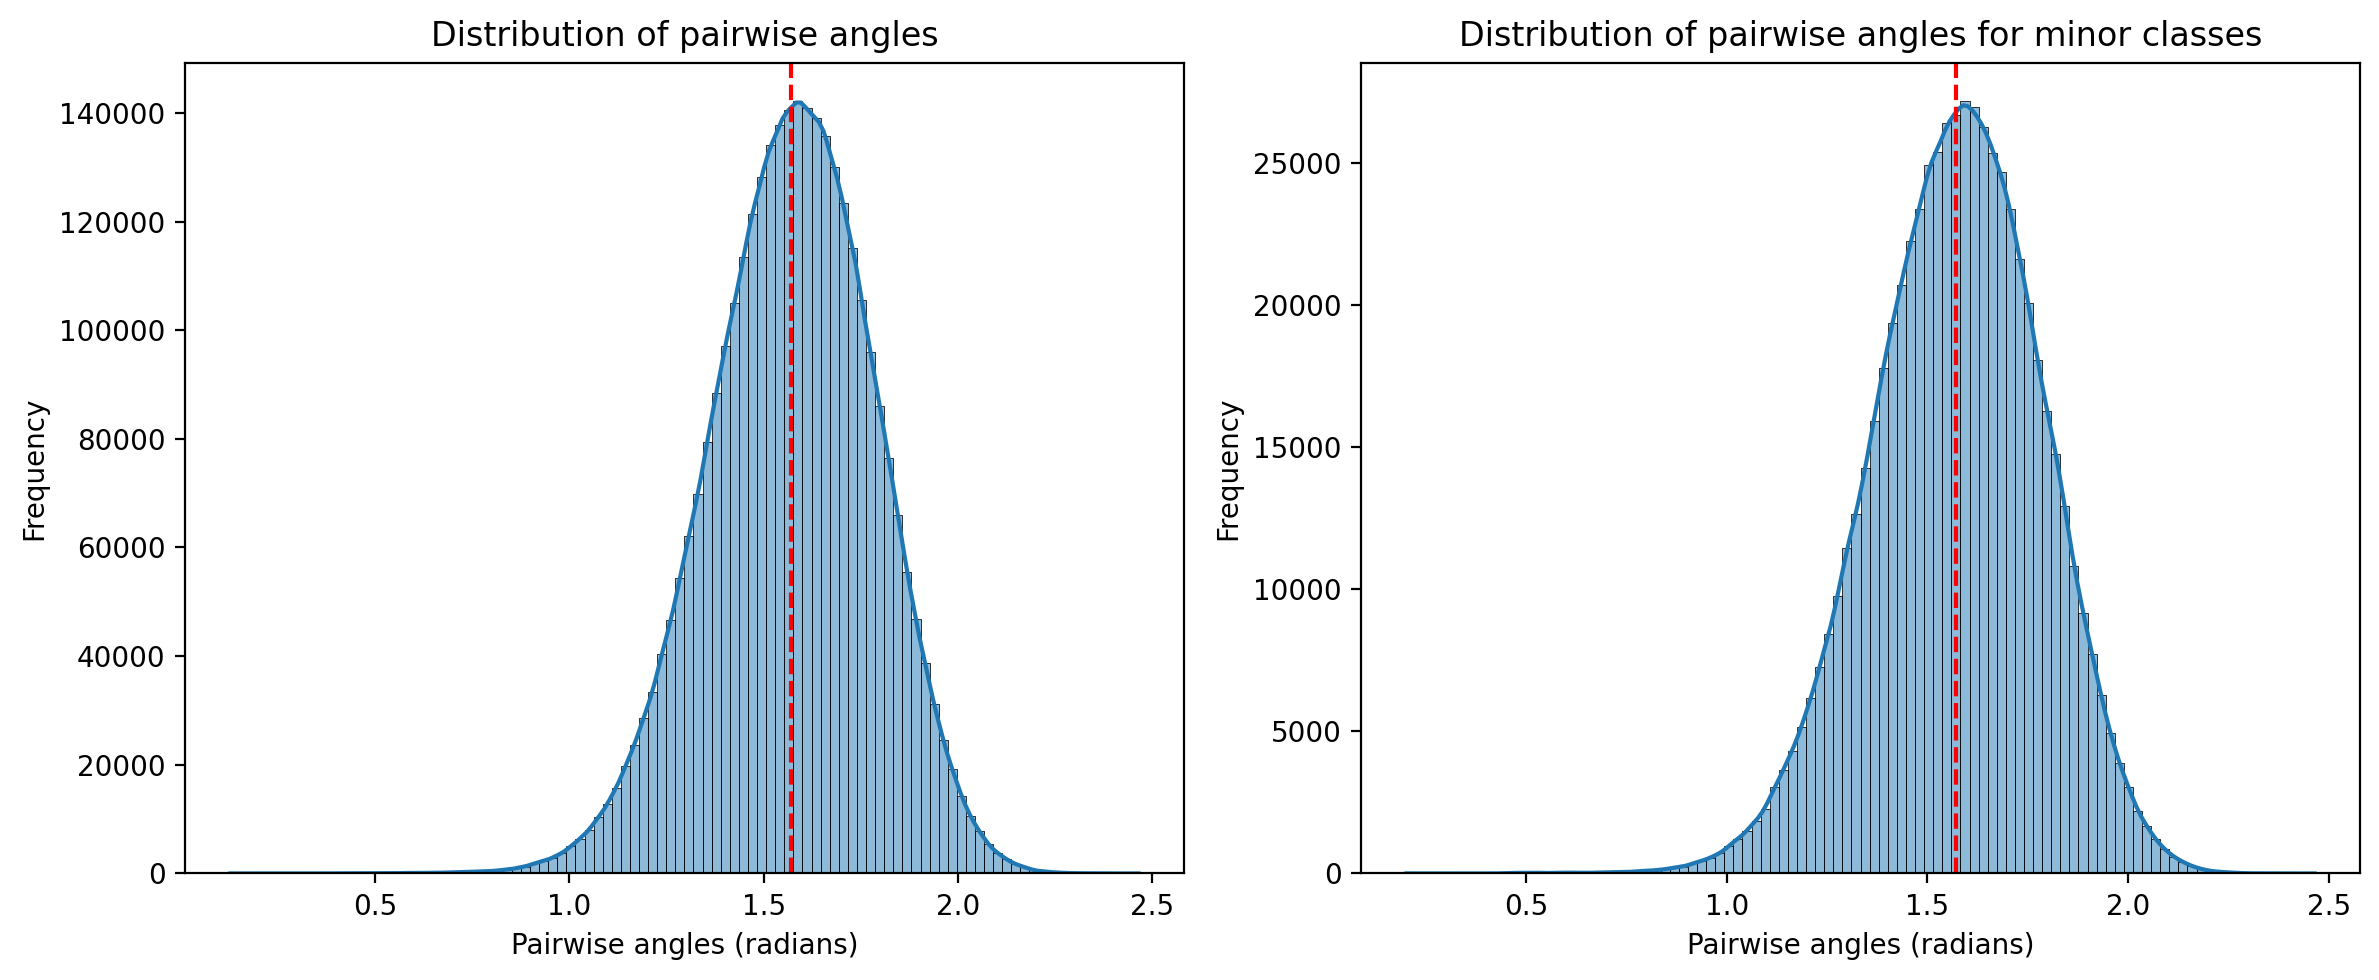

In [10]:
# pairwise angle of train_label2emb
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
import seaborn as sns

def get_ec2occurance(data_file, label_file):
    data = torch.load(data_file)
    with open(label_file, 'r') as f:
        label_list = json.load(f)
    ec2occurance = {label: 0 for label in label_list}
    for k, v in data.items():
        for label in v['ec']:
            ec2occurance[label] += 1
    
    return ec2occurance, label_list

def get_pairwise_angle(means):
    g_mean = means.mean(dim=0)
    centered_mean = means - g_mean
    means_ = F.normalize(centered_mean, p=2, dim=1)
    cosine = torch.matmul(means_, means_.t())
    angles = torch.acos(cosine)
    for i in range(angles.size(0)):
        angles[i, i] = 0
    
    return angles

label_file = '../data/ec/swissprot_ec_list_above_10.json'
ec2occurance, label_list = get_ec2occurance('../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_train.pt', label_file)
means = torch.vstack(list(train_label2emb.values()))
angles = get_pairwise_angle(means)
# get the max and min and std of angles while ignoring the diagonal elements
max_angle = torch.max(angles[torch.eye(angles.size(0)) == 0])
min_angle = torch.min(angles[torch.eye(angles.size(0)) == 0])
std_angle = torch.std(angles[torch.eye(angles.size(0)) == 0])
print(f'max_angle: {max_angle}, min_angle: {min_angle}, std_angle: {std_angle}')
# flatten the angles while ignoring the diagonal elements
angles_flattened = angles[torch.eye(angles.size(0)) == 0].flatten()

labels = list(train_label2emb.keys())
le10_label_indices = [i for i in range(len(labels)) if ec2occurance[labels[i]] < 10]
le10_angles = angles[le10_label_indices]
le10_angles_non_zero = le10_angles[le10_angles != 0]
# get the max and min and std of angles while ignoring the zero elements
print(f'<10 minor classes: max_angle: {torch.max(le10_angles_non_zero)}, min_angle: {torch.min(le10_angles_non_zero)}, std_angle: {torch.std(le10_angles_non_zero)}')

# plot the distribution of the pairwise angles
# mark a vertical line at k=torch.acos(-1/1919)
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=200)
sns.histplot(angles_flattened, ax=axes[0], bins=100, kde=True)
axes[0].axvline(torch.acos(torch.tensor(-1/1919)), color='r', linestyle='--')
axes[0].set_xlabel('Pairwise angles (radians)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of pairwise angles')
# axes[0].set_xlim(1.5, 1.8)

sns.histplot(le10_angles_non_zero, ax=axes[1], bins=100, kde=True)
axes[1].axvline(torch.acos(torch.tensor(-1/1919)), color='r', linestyle='--')
axes[1].set_xlabel('Pairwise angles (radians)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of pairwise angles for minor classes')
# axes[1].set_xlim(1.5, 1.8)

plt.tight_layout()
plt.show()

/work/jiaqi/software/miniconda3/envs/protein/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/jiaqi/software/miniconda3/envs/protein/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


max: 0.5004723764517728, min: 0.0
<10 minor classes: max: 0.4214188866317272, min: 0.0


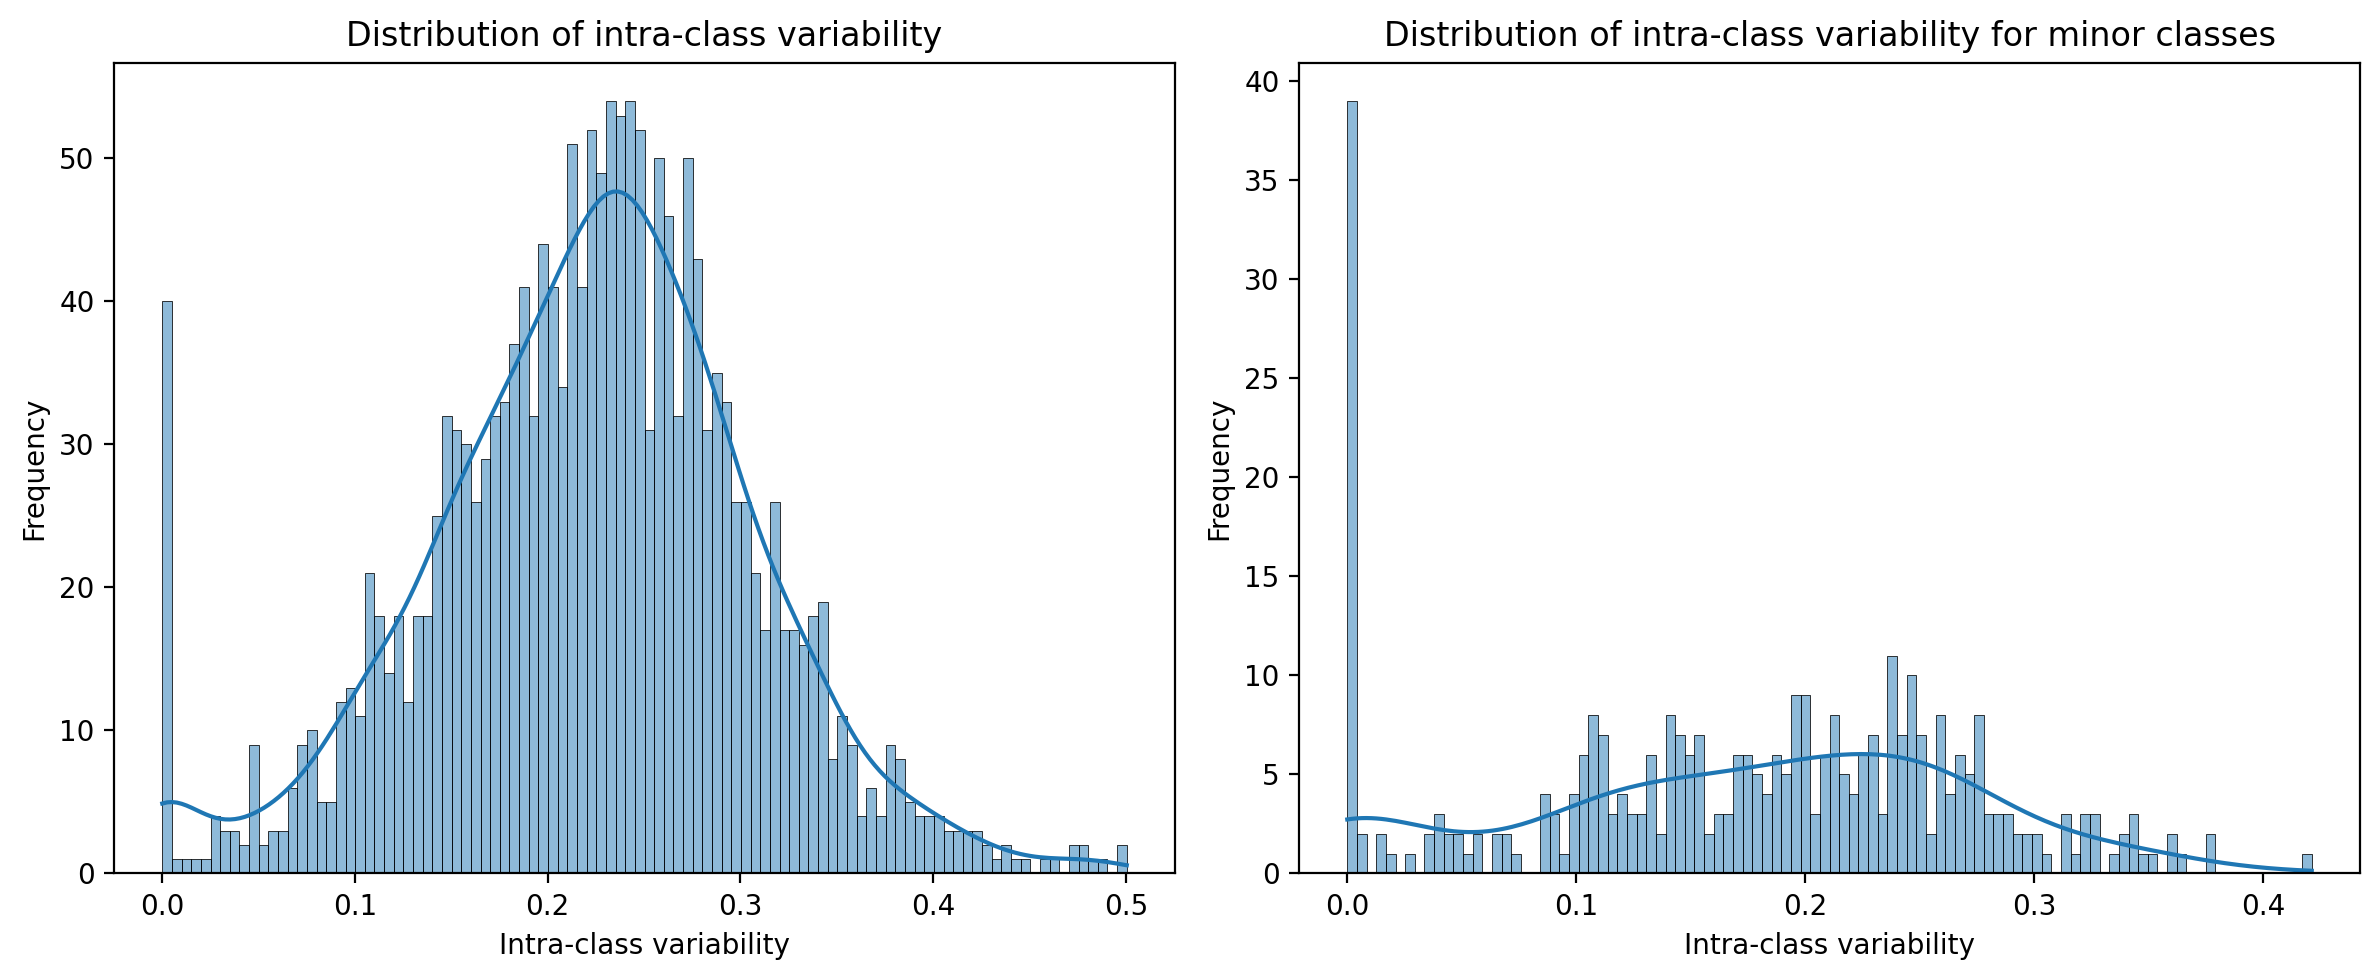

In [20]:
# investigate NC1 especially for minor classes
import numpy as np
# var(||h_i-\mu_k||)
train_label2intra_class_var = {label: [] for label in label_list}
train_embeddings_normed = F.normalize(train_CLEAN_emb, p=2, dim=1)
train_label2emb_normed = {label: F.normalize(train_label2emb[label], p=2, dim=0) for label in train_label2emb}
n_train = len(train_embeddings_normed)
label2idx = {label: i for i, label in enumerate(labels)}
for i in range(n_train):
    label = train_labels[i]
    train_label2intra_class_var[label].append(torch.norm(train_embeddings_normed[i] - train_label2emb_normed[label], p=2).item())
train_label2intra_class_var = {label: np.mean(var) for label, var in train_label2intra_class_var.items()}
train_intra_class_var = list(train_label2intra_class_var.values())
print(f'max: {max(train_intra_class_var)}, min: {min(train_intra_class_var)}')

le10_train_label2intra_class_var = {label: train_label2intra_class_var[label] for label in label_list if ec2occurance[label] < 10}
# print(len(le10_train_label2intra_class_var))
le10_train_intra_class_var = list(le10_train_label2intra_class_var.values())
print(f'<10 minor classes: max: {max(le10_train_intra_class_var)}, min: {min(le10_train_intra_class_var)}')

# plot the distribution of the intra-class variance
figures, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=200)
sns.histplot(train_intra_class_var, ax=axes[0], bins=100, kde=True)
axes[0].set_xlabel('Intra-class variability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of intra-class variability')

sns.histplot(le10_train_intra_class_var, ax=axes[1], bins=100, kde=True)
axes[1].set_xlabel('Intra-class variability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of intra-class variability for minor classes')

plt.tight_layout()
plt.show()

In [19]:
emb = train_CLEAN_emb[0]
emb_label = train_labels[0]
ec_emb = train_label2emb[emb_label]
dist = torch.norm(emb - ec_emb, p=2)
print(dist)
dist_mat = torch.norm(emb - means, p=2, dim=1)
print(dist_mat.shape, dist_mat.min())

tensor(5.1806)
torch.Size([1795]) tensor(5.1806)
